<h1> <a name="titel"></a>Gearbox Simulation Model</h1>

<p><b>Simulation of the vibration behaviour of a gearbox under degradation</b></p>

<img src="__pictures/Gearbox.png" width="60%">

<h1> <a name="intro"></a>Preliminary</h1>
<p> Load Modules </p>

In [1]:
# Build In
import os
from copy import deepcopy as dc
import sys
from IPython.display import display, HTML
# Third Party
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from scipy.stats import norm
# from gearbox_functions import gearbox_functions as gf
import gearbox_functions as gf

 <p>Define Directories</p>

In [2]:
wd = os.getcwd()
if 'nt' in os.name:
    hd = r'\\imapc\benutzer\Mitarbeiterdaten\henss\_02_software\_08_github\Gearbox' # win directory  
elif 'posix' in os.name:
    hd = r'/Users/markhenss/Documents/GitHub/Gearbox' # mac directory


<p>Other</p>

In [3]:
from matplotlib import rcParams
rcParams['figure.figsize'] = [7.4803*4, 4.62309*2]
sizefactor = 2
rcParams['ytick.labelsize'] = 8 * sizefactor
rcParams['xtick.labelsize'] = 8 * sizefactor
rcParams['axes.labelweight'] = 8 * sizefactor
rcParams['axes.titleweight'] = 8 * sizefactor
rcParams.update({'font.size': 8 * sizefactor})

<h1> <a name="motivation"></a>Motivation</h1>
<br>
<li>Gear Wheel Pitting</li>
<li>Degradation dominates at one tooth only</li>

<li>Operating Strategy [Gretzinger2017]</li>
<li>Local Stress reduction</li>

<h1> <a name="intro"></a>Introduction</h1>
<br>
<li>Toolbox to simulate gearbox vibration</li>
<li>Virtual copy of an existing testbench</li>
  <ul>
    <li>Match on Vibration Spectra</li>
    <li>Match on Gear Degradation</li>
  </ul>
<li>No consideration of:</li>
  <ul>
    <li>Transmission paths formulation (Structure Borne Accoustics)</li>
    <li>Bearing Degradation (not seen in testbench)</li>
  </ul>


<p>Acts as a state model:</p>

<li>Executes for a given load cycle (must be greater than the previous)</li>
<li>Optional: Setting a new torque signal at the given load cycle (effecting the following load cycles)</li>
<br>

<img src="__pictures/State_Definition.png" width="80%">

<p>General Input Arguments:</p>
<li>f<sub>i</sub>: Rotational Frequency input shaft - in revolutions per second (float)</li>
<li>t<sub>i</sub>: Sample Interval - in seconds (float)</li>
<li>f<sub>s</sub>: Sample Rate - in Hz (float)</li>
<li>seed: Random Generator Seed (integer)</li>

<p>Input Arguments <b>vibrations = model.run()</b>:</p>
<li>n<sub>lc</sub>: Current number of load cycle - in revolutions (float)</li>


<p>Input Arguments <b>model.set()</b>:</p>
<li>n<sub>lc</sub>: Current number of load cycle - in revolutions (float)</li>
<li><a href="torque">torque</a>: Input Torque - in Nm</li>



<p><b>Output is calculated for previous given torque<sub>p-1</sub> argument.</b></p>
<p>Given Input Torque will be relevant in next time step n<sub>lc</sub></p>



<h3>Torque</h3>

<p>Definition:</p>
<li>Must be defined as array</li>
<li>Each value corresponds to a given time</li>
<li>Function <u>'get_sample_time_torque()'</u> returns the time vector for torque</li>
<li>Length of the torque vector must be at least as long as it takes for running once every possible meshing</li>

<h1> <a name="modules"></a>Module Structure</h1>


<img src="__pictures/Modules.png" width="80%">



<li>GearBox Simulation Toolbox is structured in Modules</li>
<li>Top Modules are accesing lower Modules</li>
<li>Helper-Module is used by Modules on the same level</li>
<li>Modules consisting of several Module Methods</li>

<h1> <a name="intro"></a>Vibration</h1>

<p>Module Methods Structure:</p>

<img src="__pictures/Vibration_Method.png" width="100%">




<p>Required Inputs:</p>
<li>General Input Arguments (previous slides)</li>
<li>Vibration Method Definition for each Element (see following slides)</li>
<li>State of Degradation (given by degradation model)</li>

<p>Methods and Returns:</p>
<li>run(): Vibration Signal (for state s<sub>p</sub> = n<sub>lc</sub> based on previous torque<sub>p-1</sub>)</li>
<li>set(): Loads per tooth/bearing (based on current torque<sub>p</sub>)</li>


<h3>Element Method</h3>
<br>

<li>Creating Base Signals for Bearing and Gear Elements</li>
<li>Amplitude of +-1</li>
<li>For Bearing choose any stationary signal: 'sine'</li>
<li>For Gear choose any nonstationary signal: <a href="https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.gausspulse.html">'gausspulse'</a> <br>
</li>


<p>Example Non-Stationary Sine Signal</p>

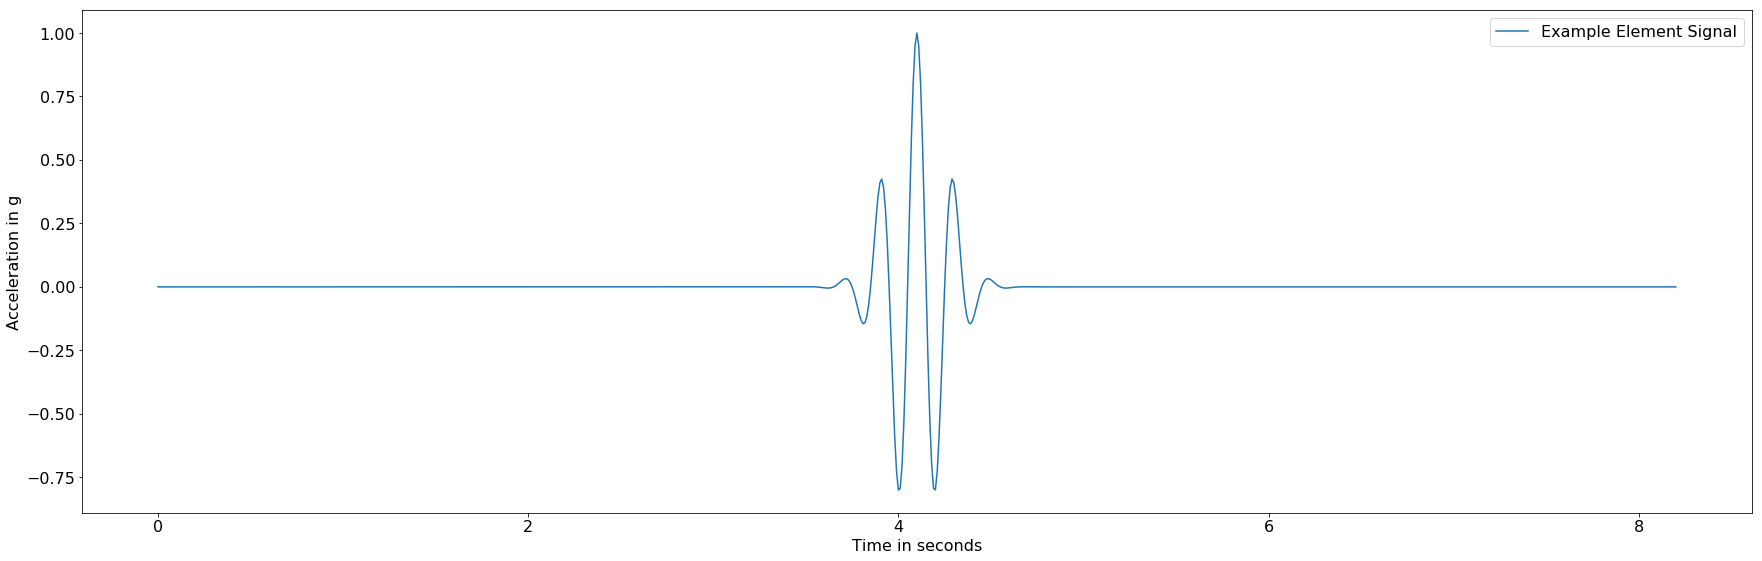

In [4]:
from scipy.signal import gausspulse
fi, fs = 5, 100
time_vector = gf.get_sample_time_torque(fi, fs, 21, 41)
element_signal = gausspulse(np.linspace(-max(time_vector)/2, max(time_vector)/2, time_vector.size), fc=fi, bw=0.5, bwr=-6, tpr=-60, retquad=False, retenv=False) # Nm | array

plt.plot(time_vector, element_signal)
plt.xlabel('Time in seconds'), plt.ylabel('Acceleration in g'), plt.legend(['Example Element Signal'])
plt.show()

<p>Example Stationary Sine Signal</p>

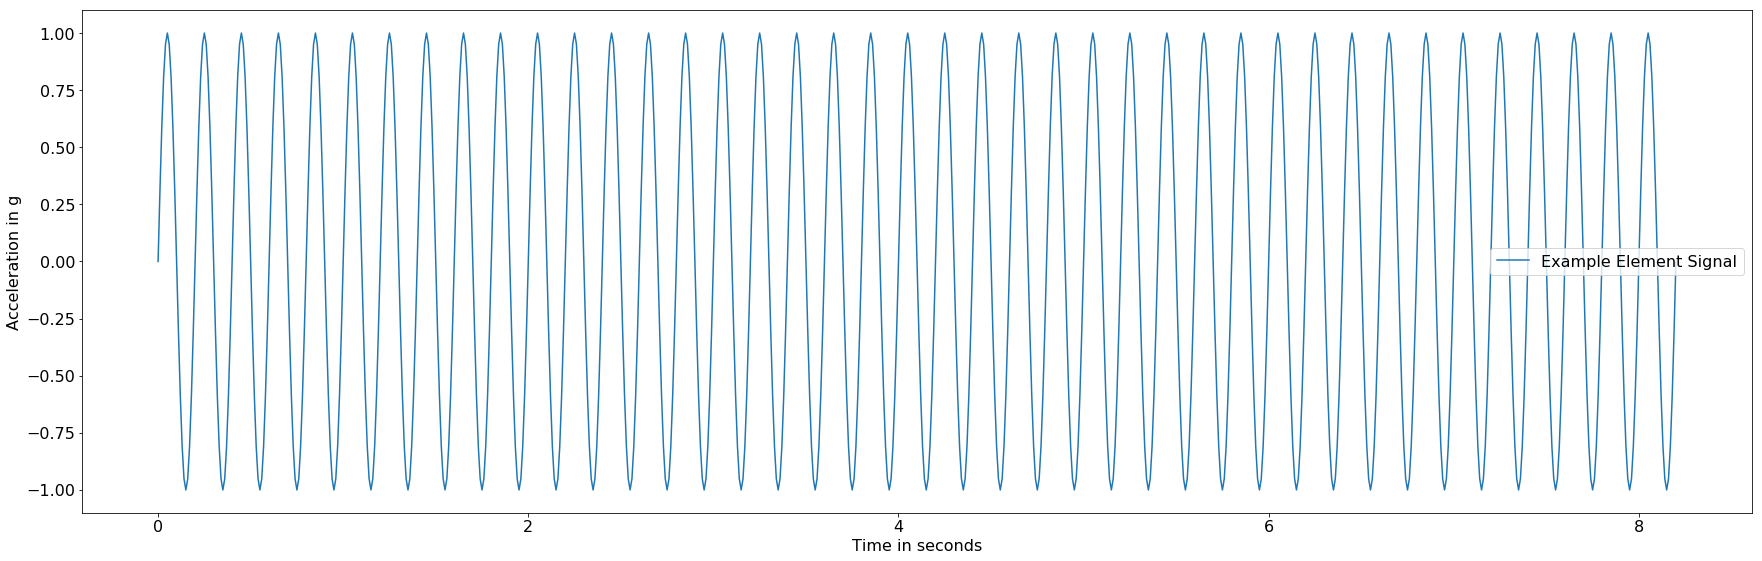

In [5]:
fi, fs = 5, 100
time_vector = gf.get_sample_time_torque(fi, fs, 21, 41)
element_signal = np.sin((2 * np.pi * fi * time_vector)) # Nm | array

plt.plot(time_vector, element_signal)
plt.xlabel('Time in seconds'), plt.ylabel('Acceleration in g'), plt.legend(['Example Element Signal'])
plt.show()

<h3>Amplitude Method</h3>
<br>

<li>Scaling the Base Signals</li>
<li>Various methods can be chosen (depending on Element)</li>
<li>Depending on the chosen Method, different Attributes must be given</li>
<li>'repeat' Methods create a pattern which will be repeated</li>

<p>Methods:</p>
<li>None: Method not used</li>
<li>'const': Constant Amplitude for all teeth and all tooth mesh repetitions (<u>attributes:</u> 'constant' (scalar))</li>
<li>'const_repeat': Constant Amplitude for each tooth (list), and unchanging over all tooth mesh repetitions (<u>attributes:</u> 'constant' (list, tuple))</li>
<li>'gaussian': Gaussian Random Amplitude for all teeth and all tooth mesh repetitions (<u>attributes:</u> 'mu' (scalar), 'sigma' (scalar)) </li>
<li>'gaussian_repeat': Gaussian Random Amplitude for each tooth, and unchanging over all tooth mesh repetitions (<u>attributes:</u> 'mu' (scalar), 'sigma' (scalar)) </li>


<p>Example Stationary Sine Signal * const Amplitude</p>

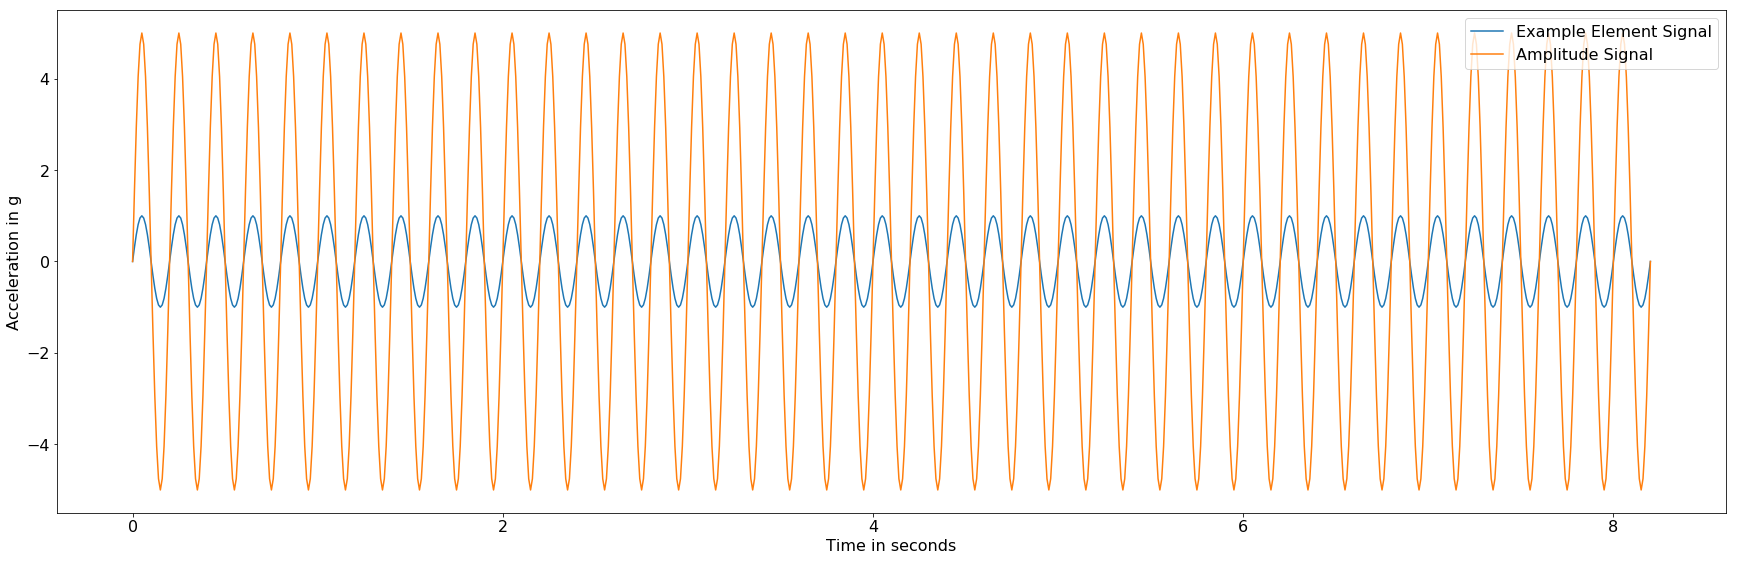

In [6]:
const = 5
amplitude_signal = element_signal * const

plt.plot(time_vector, element_signal, time_vector, amplitude_signal)
plt.xlabel('Time in seconds'), plt.ylabel('Acceleration in g'), plt.legend(['Example Element Signal', 'Amplitude Signal'])
plt.show()

<h3>Noise Method</h3>
<br>

<li>Adds noise to the signal</li>
<li>Based on the Amplitude Methods Toolbox (repeat methods are not working)</li>
<li>General use: Adding Gaussian Noise</li>

<p>Methods:</p>

<li>None: Method not used</li>
<li>'const': Constant Amplitude for all teeth and all tooth mesh repetitions (<u>attributes:</u> 'constant' (scalar))</li>
<li><strike>'const_repeat': Constant Amplitude for each tooth (list), and unchanging over all tooth mesh repetitions (<u>attributes:</u> 'constant' (list, tuple))</strike></li>
<li>'gaussian': Gaussian Random Amplitude for all teeth and all tooth mesh repetitions (<u>attributes:</u> 'mu' (scalar), 'sigma' (scalar)) </li>
<li><strike>'gaussian_repeat': Gaussian Random Amplitude for each tooth, and unchanging over all tooth mesh repetitions (<u>attributes:</u> 'mu' (scalar), 'sigma' (scalar))</strike></li>

<p>Example Stationary Sine Signal * const Amplitude + noise</p>

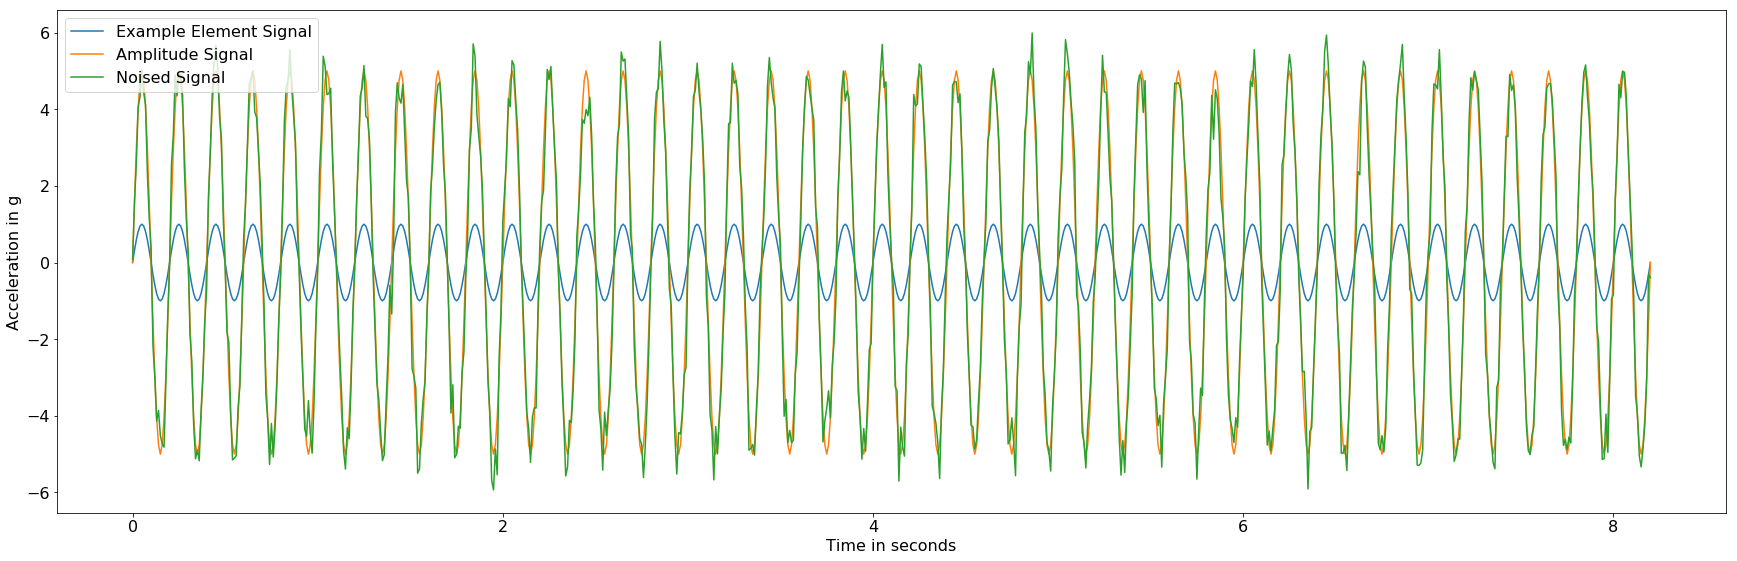

In [7]:
noise = np.random.randn(time_vector.size)*0.5
noised_signal = amplitude_signal + noise

plt.plot(time_vector, element_signal, time_vector, amplitude_signal, time_vector, noised_signal)
plt.xlabel('Time in seconds'), plt.ylabel('Acceleration in g'), plt.legend(['Example Element Signal', 'Amplitude Signal', 'Noised Signal'])
plt.show()

<h3>Torque Method</h3>
<br>

<li>Scales Signal s regarding the torque s<sub>t</sub></li>
<li>1. s<sub>t</sub> = s<sub>t</sub>/s<sub>norm</sub>, norm signal by s<sub>norm</sub></li>
<li>2. s<sub>t</sub> = f(s<sub>t</sub>), while f can be linear, polynomial and exponential</li>
<li>3. s<sub>t</sub> = scale(s<sub>t</sub>), scale into range scale_min-scale_max while scale_min corresponds to value_min and scale_max to value_max</li>
<li>4. s<sub>t</sub> = s<sub>t</sub> + 1, add one to retain origninal signal and add torque on top</li>
<li>5. s = s * s<sub>t</sub></li>

<p>Methods:</p>

<li>None: Method not used</li>
<li>'linear': f in step 2 is linear transformation (no transformation)</li>
<li>'polynomial': f in step 2 is polynomial with given exponent argument</li>
<li>'exponential': f in step 2 is exponential</li>

<p>Example Torque Signal 200 Nm +- 5 Nm</p>

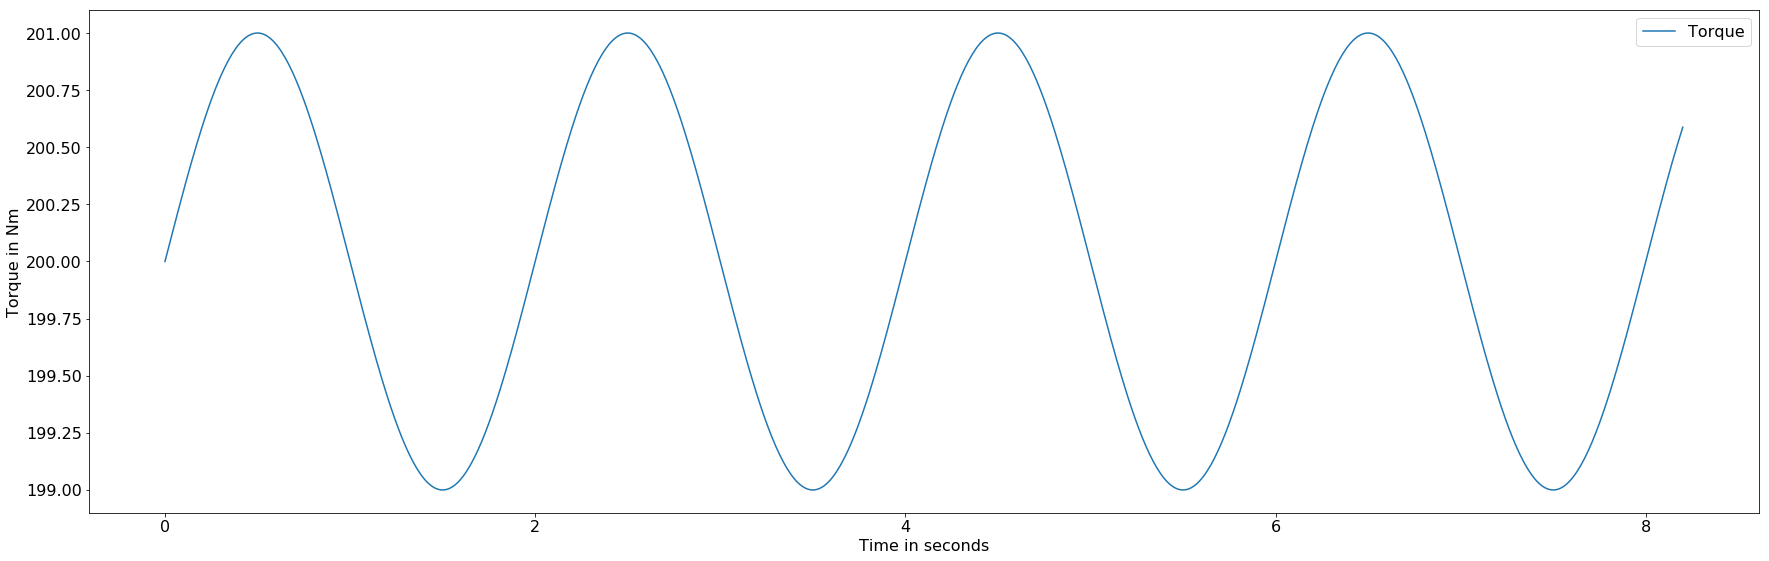

In [8]:
torque = np.sin((2 * np.pi * fi /10 * time_vector)) + 200 # Nm | array

plt.plot(time_vector, torque)
plt.xlabel('Time in seconds'), plt.ylabel('Torque in Nm'), plt.legend(['Torque'])
plt.show()


<p>Define Scale Arguments</p>

In [9]:
scale_min = 0                   
scale_max = 0.2
value_min = 1-0.01
value_max = 1.01
norm_divisor = 200
exponent = 2


<p>1. s<sub>t</sub> = s<sub>t</sub>/s<sub>norm</sub>, norm signal by s<sub>norm</sub></p>

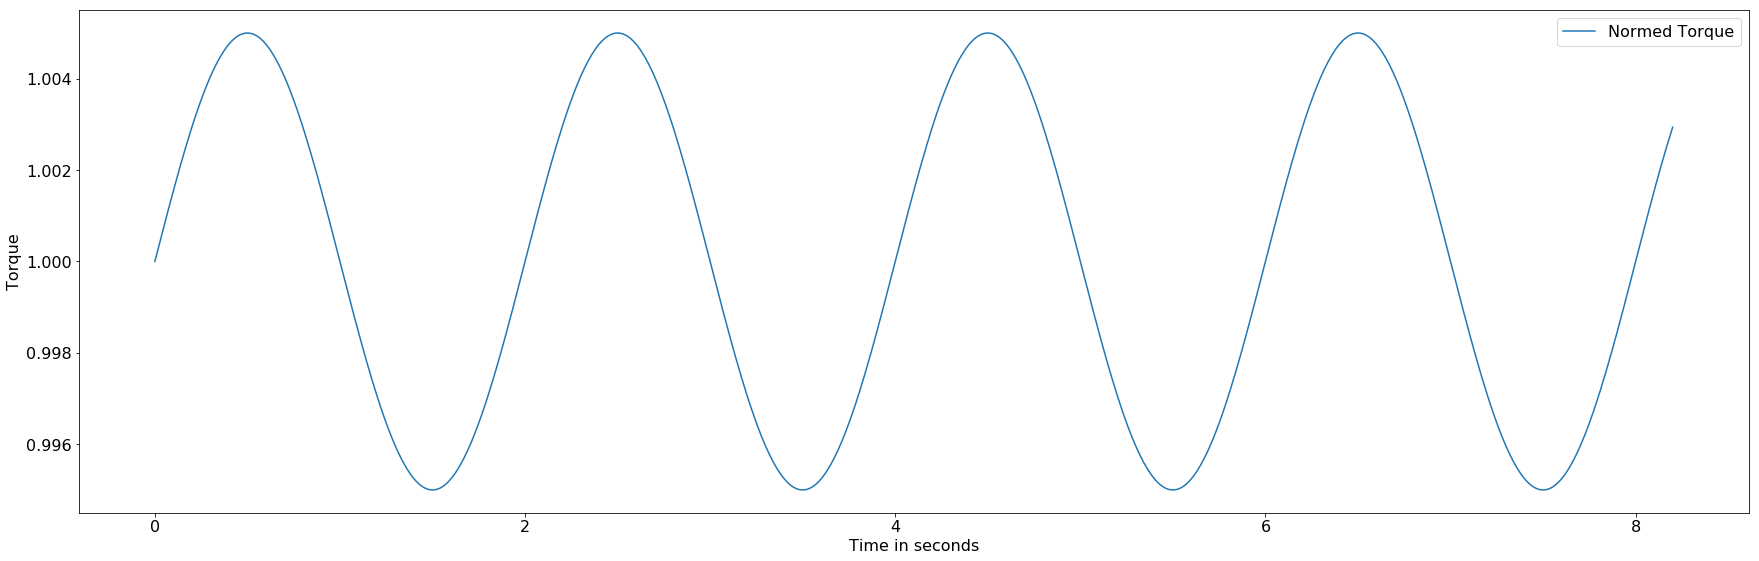

In [10]:
torque_1 = torque / norm_divisor

plt.plot(time_vector, torque_1)
plt.xlabel('Time in seconds'), plt.ylabel('Torque'), plt.legend(['Normed Torque'])
plt.show()

<p>2. s<sub>t</sub> = f(s<sub>t</sub>), while f can be linear, polynomial and exponential</p>

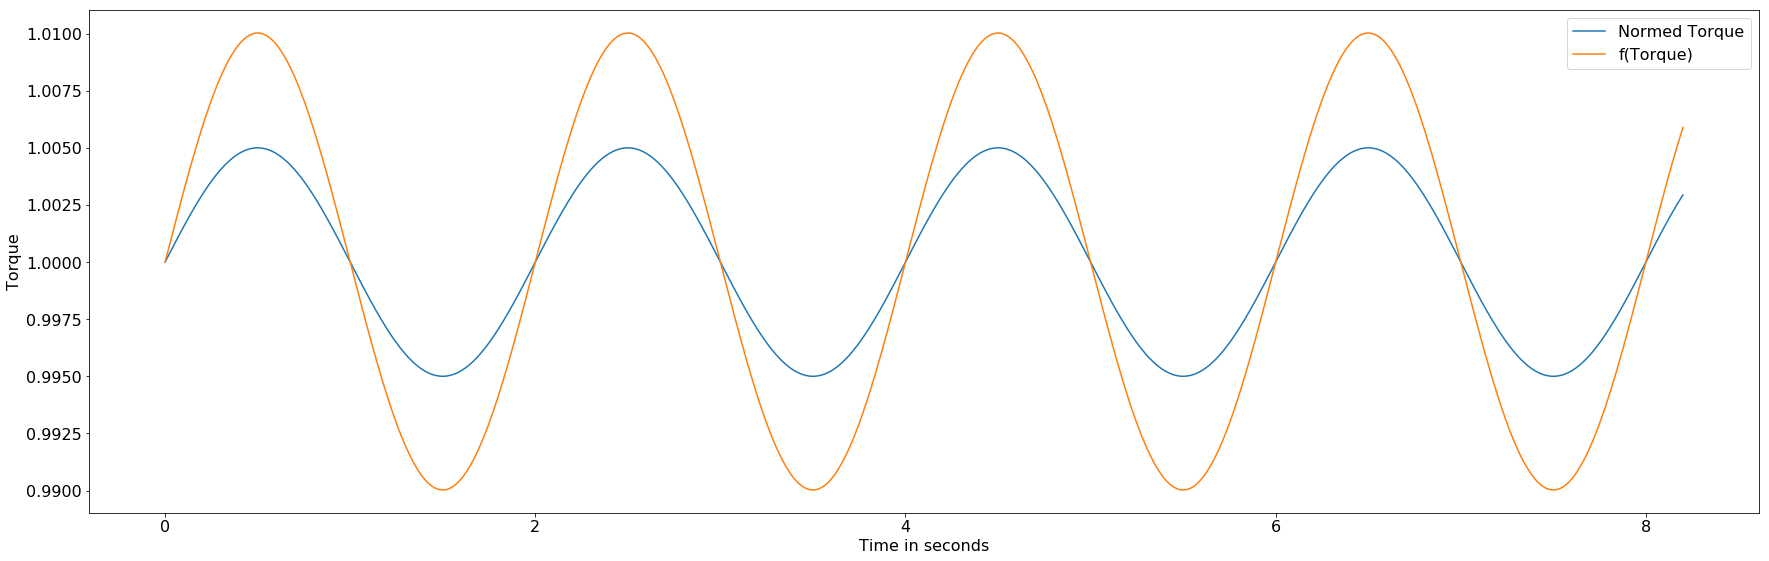

In [11]:
torque_2 = np.power(torque_1, exponent) 

plt.plot(time_vector, torque_1, time_vector, torque_2)
plt.xlabel('Time in seconds'), plt.ylabel('Torque'), plt.legend(['Normed Torque', 'f(Torque)'])
plt.show()

<p>3. s<sub>t</sub> = scale(s<sub>t</sub>), scale into range scale_min-scale_max while scale_min corresponds to value_min and scale_max to value_max</p>

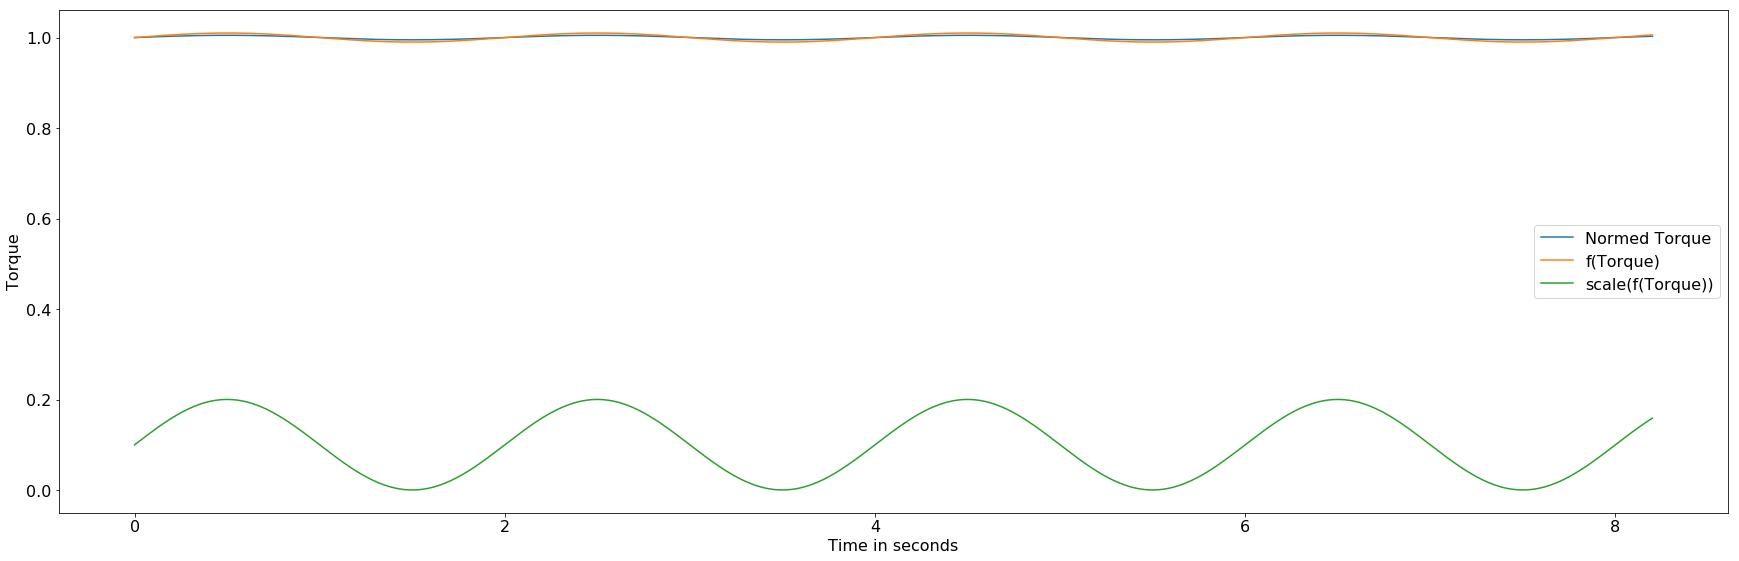

In [12]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(scale_min, scale_max))
scaler.fit(np.array([value_min, value_max]).reshape(-1, 1))
torque_3 = scaler.transform(torque_2.reshape(-1, 1)) 

plt.plot(time_vector, torque_1, time_vector, torque_2, time_vector, torque_3)
plt.xlabel('Time in seconds'), plt.ylabel('Torque'), plt.legend(['Normed Torque', 'f(Torque)', 'scale(f(Torque))'])
plt.show()

<p>4. s<sub>t</sub> = s<sub>t</sub> + 1, add one to retain origninal signal and add torque on top</p>

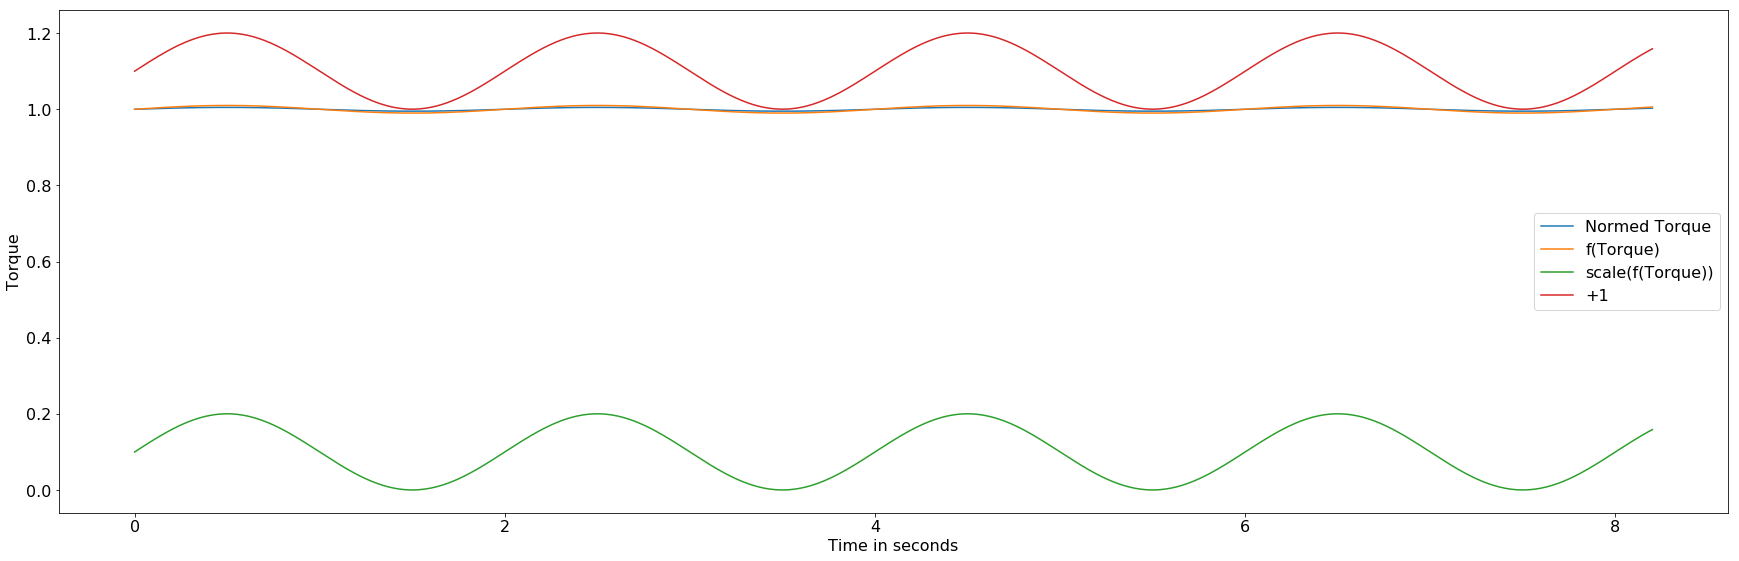

In [13]:
torque_4 = torque_3 + 1 

plt.plot(time_vector, torque_1, time_vector, torque_2, time_vector, torque_3, time_vector, torque_4)
plt.xlabel('Time in seconds'), plt.ylabel('Torque'), plt.legend(['Normed Torque', 'f(Torque)', 'scale(f(Torque))', '+1'])
plt.show()

<p>5. s = s * s<sub>t</sub></p>
<p>(Example Stationary Sine Signal * const Amplitude + noise) * Torque</p>

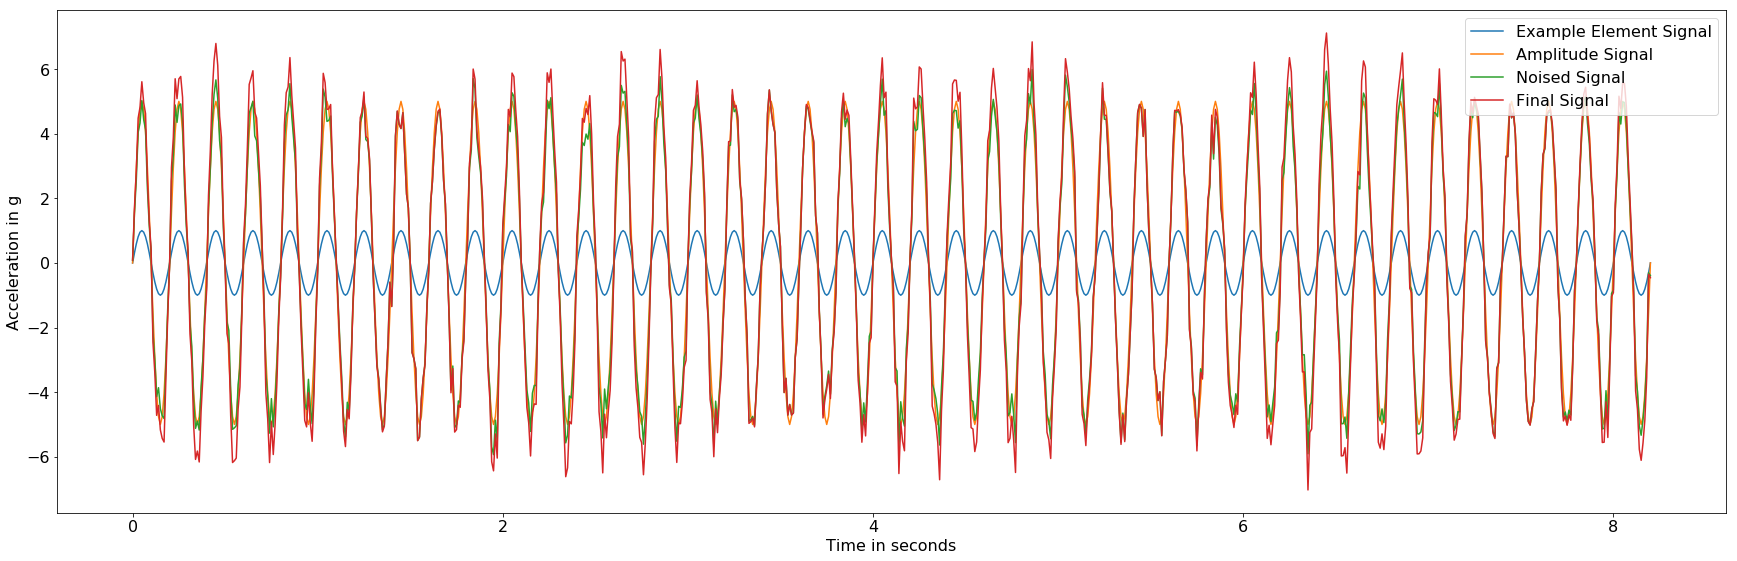

In [14]:
final_signal = noised_signal * torque_4.reshape(-1)

plt.plot(time_vector, element_signal, time_vector, amplitude_signal, time_vector, noised_signal, time_vector, final_signal)
plt.xlabel('Time in seconds'), plt.ylabel('Acceleration in g'), plt.legend(['Example Element Signal', 'Amplitude Signal', 'Noised Signal', 'Final Signal'])
plt.show()

<h1> <a name="gear-vibration"></a>Gear Vibration Definition</h1>

<p>General Gear Element Definition (Keyword Attributes): <br>
<ol>
    <li><b>no_teeth: Number of teeth</b> <br></li>
    <li>signal: <a href="NonstationarySignals">Nonstationary Signals</a><br></li>
    <li>ampl_method: <a href="AmplitudeMethod">Method to create Signal Amplitude</a><br></li>
    <li>ampl_attributes: <a href="AmplitudeMethod">Attributes regarding the Method to create Signal Amplitude</a><br></li>
    <li>noise_method:  <a href="AmplitudeMethod">Method to create Signal Noise (repeat methods are not working)</a><br></li>
    <li>noise_attributes: <a href="AmplitudeMethod">Attributes regarding the Method to create Signal Noise</a><br></li>
    <li>torq_method:  <a href="TorqueMethod">Method to create Signal Noise (repeat methods are not working)</a><br></li>
    <li>torq_attributes: <a href="TorqueAmplitudeMethod">Attributes regarding the Method to create Signal Noise</a><br></li>
</ol>
</p>


<p>Gear Element:</p>

In [15]:
Gear = {'no_teeth': 10,                                         # Number of teeth
        'signal': 'gausspulse',                                 # Signal type for gear
        'ampl_method': 'gaussian_repeat',                       # Amplitude Method for inner gear
        'ampl_attributes': {'mu': 4, 'sigma': 0.5},             # Attributes regarding Amplitude Method for gear signal
        'noise_method': None,                                   # Noise Method for inner gear
        'noise_attributes': {'mu': 0, 'sigma': 0.25},           # Attributes regarding Noise Method for gear signal
        'torq_method': None,                                    # Torque Influence Method for inner gear
        'torq_attributes': {'scale_min': 0,
                            'scale_max': 0.2,
                            'value_min': 0,
                            'value_max': 50,
                            'norm_divisor': 200,
                            'exponent': 2},
        }

<p>Modelling:</p>

<li>The chosen Non-Stationary Signal is repeated every tooth mesh</li>
<li>Repeat Methods are modeling the same amplitude at tooth i</li>
<li>Using const_repeat argument constant must be a list of length no_teeth</li>

<h1> <a name="bearing-vibration"></a>Bearing Vibration Definition</h1>

<p>General Bearing Element Definition (Keyword Attributes):</p><br>

<ol>
    <li><b>no_elements: Number of rolling elements</b> <br></li>
    <li>signal_*: <a href="NonstationarySignals">Nonstationary Signals</a><br></li>
    <li>ampl_method_*: <a href="AmplitudeMethod">Method to create Signal Amplitude</a><br></li>
    <li>ampl_attributes_*: <a href="AmplitudeMethod">Attributes regarding the Method to create Signal Amplitude</a><br></li>
    <li>noise_method_*:  <a href="AmplitudeMethod">Method to create Signal Noise (repeat methods are not working)</a><br></li>
    <li>noise_attributes_*: <a href="AmplitudeMethod">Attributes regarding the Method to create Signal Noise</a><br></li>
    <li>torq_method_*:  <a href="TorqueMethod">Method to create Signal Noise (repeat methods are not working)</a><br></li>
    <li>torq_attributes_*: <a href="TorqueAmplitudeMethod">Attributes regarding the Method to create Signal Noise</a><br></li>
</ol>
</p>

<p>*: Can be 'iring' (inner ring), 'relement' (rolling element) or 'oring' (ourter ring)</p>



In [16]:
Bearing =   {'no_elements': 11,                                    # Number of Rolling Elements
             # Inner Ring Rollover
             'signal_iring': 'sine',                               # Signal type for inner cage
             'ampl_method_iring': 'const',                         # Amplitude Method for inner cage signal (Repeat methods are not working for bearings)
             'ampl_attributes_iring': {'constant': 2.5},           # Attributes regarding Amplitude Method for inner cage signal
             'noise_method_iring': 'gaussian',                     # Noise Method for inner gear
             'noise_attributes_iring': {'mu': 0, 'sigma': 0.05},   # Attributes regarding Noise Method for gear signal
             'torq_method_iring': None,                         # Torque Influence Method for rolling element
             'torq_attributes_iring': {'scale_min': 0,          # Attributes regarding Torque Influence Method for rolling element signal
                                       'scale_max': 0.1,
                                       'value_min': 0,
                                       'value_max': 50,
                                       'norm_divisor': 1,
                                       'exponent': 4},           

             # Rolling Element:
             'signal_relement': 'sine',                            # Signal type for rolling element
             'ampl_method_relement': 'const',                      # Amplitude Method for rolling element signal (Repeat methods are not working for bearings)
             'ampl_attributes_relement': {'constant': 1.2},        # Attributes regarding Amplitude Method for rolling element signal
             'noise_method_relement': 'gaussian',                  # Noise Method for rolling element
             'noise_attributes_relement': {'mu': 0, 'sigma': 0.05},# Attributes regarding Noise Method for gear signal
             'torq_method_relement': None,                         # Torque Influence Method for rolling element
             'torq_attributes_relement': {'scale_min': 0,          # Attributes regarding Torque Influence Method for rolling element signal
                                          'scale_max': 0.1,
                                          'value_min': 0,
                                          'value_max': 50,
                                          'norm_divisor': 1,
                                          'exponent': 4},
             # Outer Ring Rollover
             'signal_oring': 'sine',                               # Signal type for inner cage
             'ampl_method_oring': 'const',                         # Amplitude Method for inner cage signal (Repeat methods are not working for bearings)
             'ampl_attributes_oring': {'constant': 2.5},           # Attributes regarding Amplitude Method for inner cage signal
             'noise_method_oring': 'gaussian',                     # Noise Method for inner gear
             'noise_attributes_oring': {'mu': 0, 'sigma': 0.05},   # Attributes regarding Noise Method for gear signal
             'torq_method_oring': None,                         # Torque Influence Method for rolling element
             'torq_attributes_oring': {'scale_min': 0,          # Attributes regarding Torque Influence Method for rolling element signal
                                       'scale_max': 0.1,
                                       'value_min': 0,
                                       'value_max': 50,
                                       'norm_divisor': 1,
                                       'exponent': 4},          
            }

<p>Modelling:</p>

<li>The frequencies for the chosen Stationary Signal are estimated by VDI 3832 (Estimation without geometrical dimensions)</li>
<li>Repeat Methods are not working</li>
<li>As approximation factor 0.425 is chosen</li>
<br>
<div class="container">
    <div class="col-lg-6 col-md-6  col-sm-2">
      <img src="__pictures/VDI3832_Bearing_formula.png" width="75%">
    </div>
    <div class="col-lg-6 col-md-6  col-sm-2" >
      <img src="__pictures/VDI3832_Bearing_symbols.png" width="75%">
    </div>
<div>




<h1> <a name="degradation"></a>Degradation</h1>

<p>Module Methods Structure:</p>

<img src="__pictures/Degradation_Method.png" width="100%">




<p>Required Inputs:</p>
<li>Failing Teeth: Number of teeth failing at given Gear</li>
<li>Chances: Various chances influencing the teeth failing order</li>
<li>PDF_Deg_Init: PDF for pitting_size and load_cycles @ pitting initialization</li>
<li>PDF_Deg_EOL: PDF for pitting_size and load_cycles @ pitting end of life</li>
<li>Woehler: Woehler Definition</li>
<li>GridSearch: Slices for exp.-function Parameters to be determined in Gridsearch</li>


In [17]:
Deg_Gear = {'Failing_Teeth': 2,                                      # Number of Teeth falling at Gear
            'Chances': {'neighbouring': 1,                           # Chance that multiple falling teeth are neighbouring 
                        'opposite': 1,                               # Chance that multiple falling teeth are opposite to each other 
                        'keeporder': 10},                            # Chance that multiple falling teeth are keeping order from init to eol
            'PDF_Deg_Init': {'n': norm(loc=6.875e6, scale=1.053e6),  # P(n_0)
                             'a': norm(loc=0.450, scale=0.305)},     # P(a_0)
            'PDF_Deg_EOL': {'n': norm(loc=10390000, scale=1.053e6),  # P(n_eol)
                            'a': norm(loc=4.0, scale=0.)},           # P(a_eol)
            'Woehler': {'k': 10.5,                                   # Woehler Exponent 
                        'np': 10390000,                              # Woehler Reference n
                        'torqp': 200},                               # Woehler Reference sigma in Nm
            'GridSearch': {'slice_theta1': (0.0001, 0.0902, 0.01),   # Grid for function a = theta1 * exp(theta2 * n) + theta3 defined in slices
                           'slice_theta2': (0.10/1e6, 1.51/1e6, 0.2/1e6), #tbd change step to 0.02/1e6
                           'slice_theta3':(-2.0, 0.5, 0.1)}
           }

<p>Load the Gear Degradation Module for demonstration purposes</p>

In [18]:
# os.chdir()
os.chdir(hd)
from gearbox.degradation.gear import Gear_Degradation
os.chdir(wd)

<h3>Chances</h3>
<br>

<p>Chances are descriping <u>how many times more likely</u> it is that an event occurs compared to the event dont occure</p>
<p>Events:</p>
<li>neighbouring: The next failing tooth is a neighbour of an already fallen one</li>
<li>opposite: The next failing tooth is opposite of an already fallen one</li>
<li>keeporder: The teeth are keeping the same order in initialization and end of life (first tooth with initialization is also the first reachning end of life</li>


<p>Random Pitting Initialization</p>

In [70]:
Deg_Gear['Chances'] = {'neighbouring': 1, 'opposite': 1, 'keeporder': 1}  
deg_model = Gear_Degradation(17, Deg_Gear, 1)
deg_model.get_initial_values()

deg_model.state0.head()

,a0,n0,tooth,neol,aeol
0,0.122745,5.716048e+06,13,1.130127e+07,4.0
1,0.895943,5.889635e+06,17,7.966480e+06,4.0
2,0.945425,5.950615e+06,8,9.833835e+06,4.0
3,0.397409,5.984998e+06,4,9.985591e+06,4.0
4,0.332863,6.146681e+06,11,8.220672e+06,4.0


<p>Visualization of Pitting Size at Initialization</p>

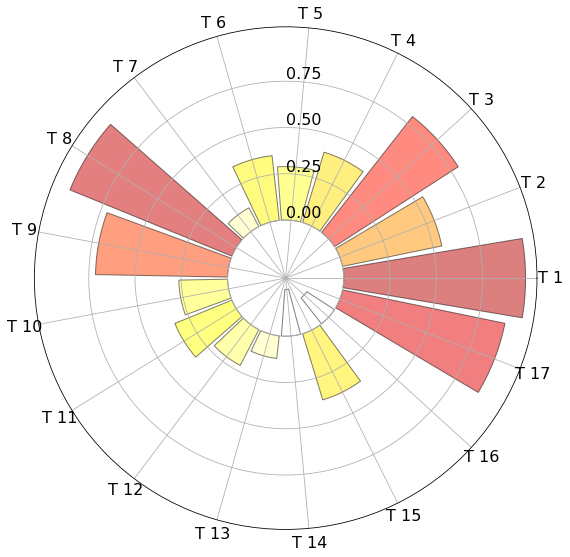

In [116]:
gf.plot_gear_polar(deg_model.state0, kind='pitting', key='a0')

<p>Pitting Order Visualization</p>

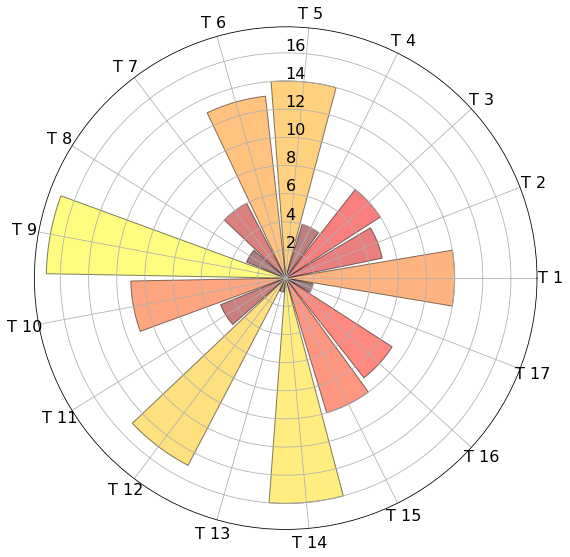

In [71]:
gf.plot_gear_polar(deg_model.state0, kind='order')

<p>Neighbouring favoured Pitting Initialization</p>

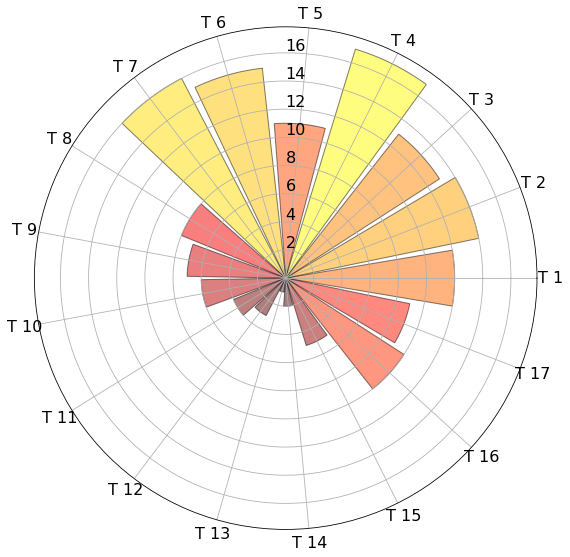

In [69]:
Deg_Gear['Chances'] = {'neighbouring': 100, 'opposite': 1, 'keeporder': 1}  
deg_model = Gear_Degradation(17, Deg_Gear, 1)
deg_model.get_initial_values()
gf.plot_gear_polar(deg_model.state0, kind='order')

<p>Opposite favoured Pitting Initialization</p>

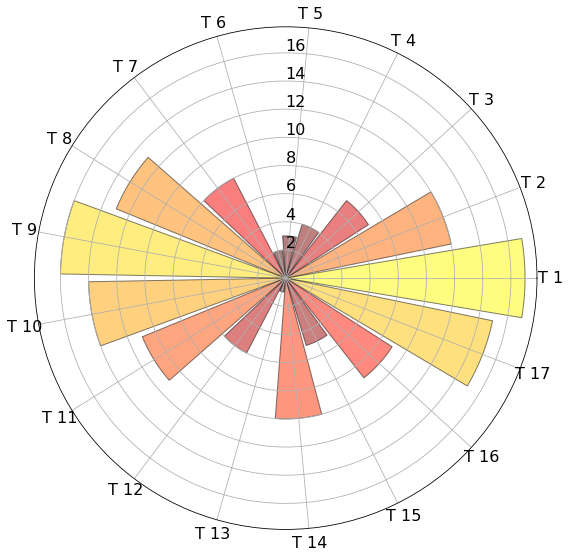

In [72]:
Deg_Gear['Chances'] = {'neighbouring': 1, 'opposite': 100, 'keeporder': 1}  
deg_model = Gear_Degradation(17, Deg_Gear, 1)
deg_model.get_initial_values()
gf.plot_gear_polar(deg_model.state0, kind='order')

<p>Neighbouring and Opposite favoured Pitting Initialization</p>

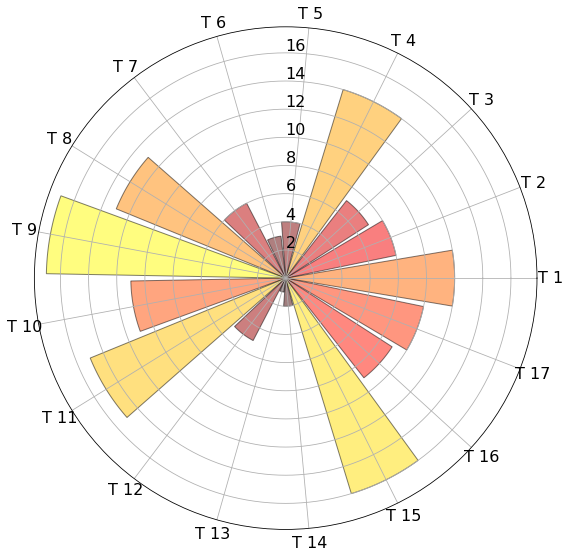

In [74]:
Deg_Gear['Chances'] = {'neighbouring': 100, 'opposite': 100, 'keeporder': 1}  
deg_model = Gear_Degradation(17, Deg_Gear, 1)
deg_model.get_initial_values()
gf.plot_gear_polar(deg_model.state0, kind='order')

<p>Keeporder favoured Initialization</p>

In [75]:
Deg_Gear['Chances'] = {'neighbouring': 1, 'opposite': 1, 'keeporder': 100}  
deg_model = Gear_Degradation(17, Deg_Gear, 1)
deg_model.get_initial_values()

deg_model.state0.head()

,a0,n0,tooth,neol,aeol
0,0.122745,5.716048e+06,13,7.966480e+06,4.0
1,0.895943,5.889635e+06,17,8.220672e+06,4.0
2,0.945425,5.950615e+06,8,9.231814e+06,4.0
3,0.397409,5.984998e+06,4,9.260164e+06,4.0
4,0.332863,6.146681e+06,11,1.222729e+07,4.0


<h3>PDF Degradation</h3>
<br>

<p>Probability Density Function for Degradation <u>Initialization</u></p>
<li>n: Initialization Load Cycle PDF - P(n<sub>0</sub>)</li>
<li>a: Initialization Pitting Size PDF - P(a<sub>0</sub>)</li>

<p>Probability Density Function for Degradation <u>End of Life</u></p>
<li>n: EOL Load Cycle PDF - P(n<sub>eol</sub>)</li>
<li>a: EOL Pitting Size PDF - P(a<sub>eol</sub>)</li>

<p> PDF can be defined as any continuous distribution function available on <a href="https://docs.scipy.org/doc/scipy/reference/stats.html">'Scipy Stats'</a></p>
<p><b>PDFs are valid for a reference torque, defined by woehler</b></p>


<p>P(n<sub>0</sub>) and P(n<sub>eol</sub>)</p>

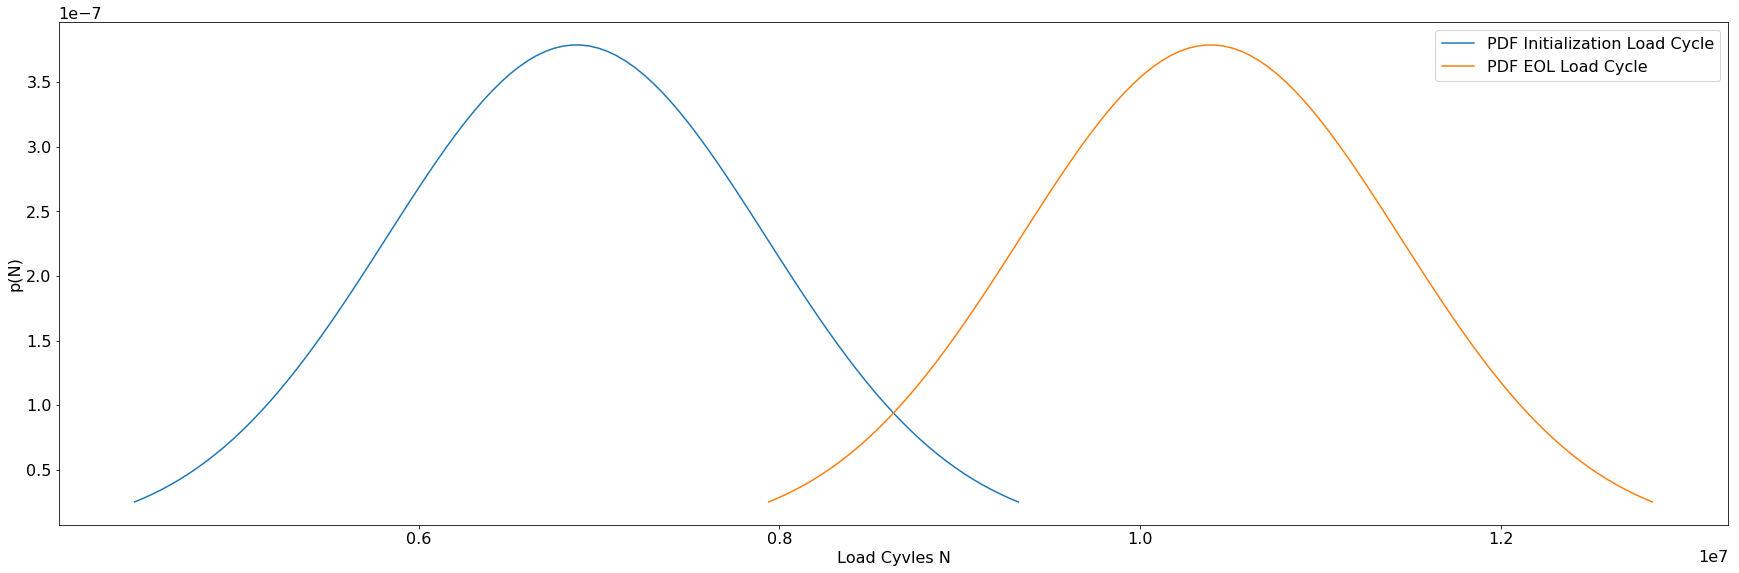

In [91]:
P_n0, P_neol= norm(loc=6.875e6, scale=1.053e6), norm(loc=10390000, scale=1.053e6)
n0, neol = np.linspace(P_n0.ppf(0.01), P_n0.ppf(0.99), 100), np.linspace(P_neol.ppf(0.01), P_neol.ppf(0.99), 100)

plt.plot(n0, P_n0.pdf(n0), neol, P_neol.pdf(neol))
plt.xlabel('Load Cyvles N'), plt.ylabel('p(N)'), plt.legend(['PDF Initialization Load Cycle', 'PDF EOL Load Cycle'])
plt.show()

<p>P(a<sub>0</sub>) and P(a<sub>eol</sub>)</p>

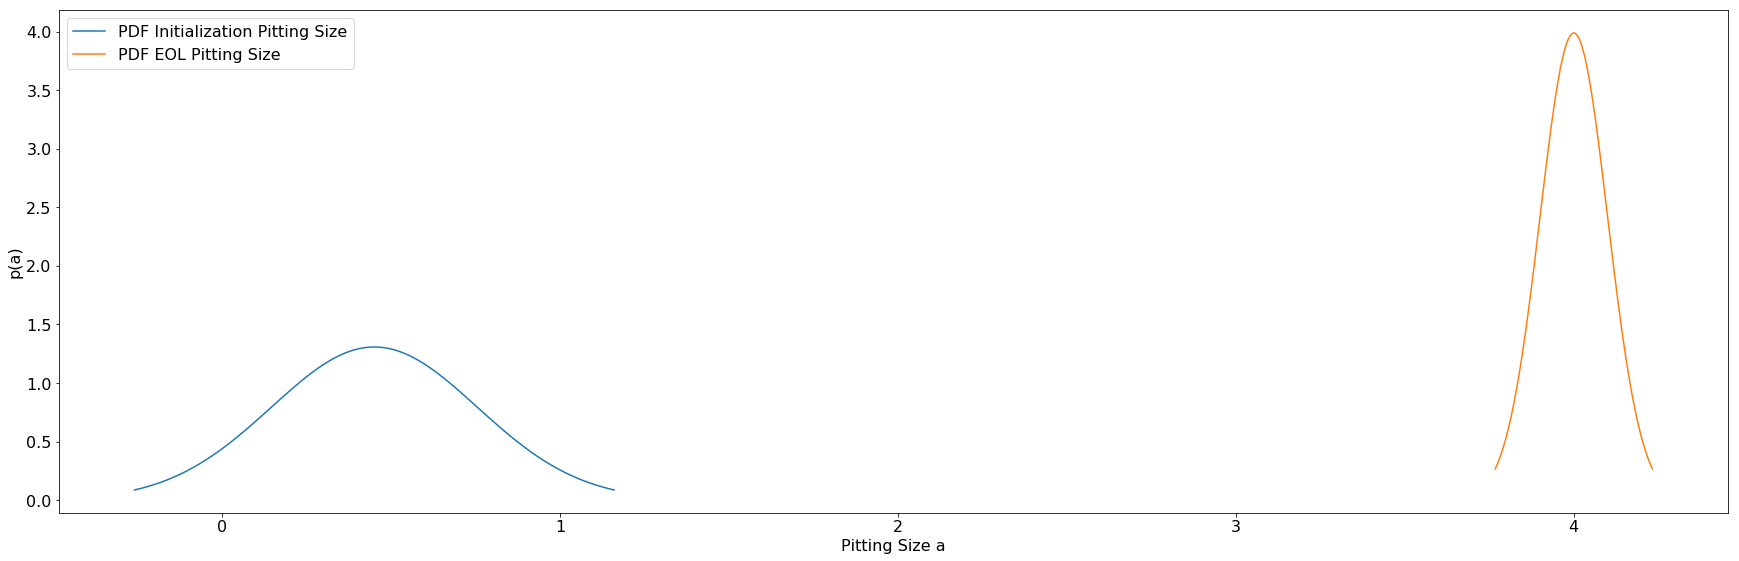

In [90]:
P_a0, P_aeol= norm(loc=0.450, scale=0.305), norm(loc=4.0, scale=0.1)
a0, aeol = np.linspace(P_a0.ppf(0.01), P_a0.ppf(0.99), 100), np.linspace(P_aeol.ppf(0.01), P_aeol.ppf(0.99), 100)

plt.plot(a0, P_a0.pdf(a0), aeol, P_aeol.pdf(aeol))
plt.xlabel('Pitting Size a'), plt.ylabel('p(a)'), plt.legend(['PDF Initialization Pitting Size', 'PDF EOL Pitting Size'])
plt.show()

<h3>Woehler Curve</h3>
<br>

<p>Definition of Woehler Curve for EOL</p>
<li>k: Woehler exponent (measure for gradien)</li>
<li>np: Reference Load Cycle on Woehler Curve - pair (np, torquep)</li>
<li>torquep: Reference Torque on Woehler Curve - pair (np, torquep)</li>


<p>The definition of the reference points (np, torquep) also determines the probability of failure Px for which the Woehler line applies.</p>




<p>Woehler Curve Plot</p>

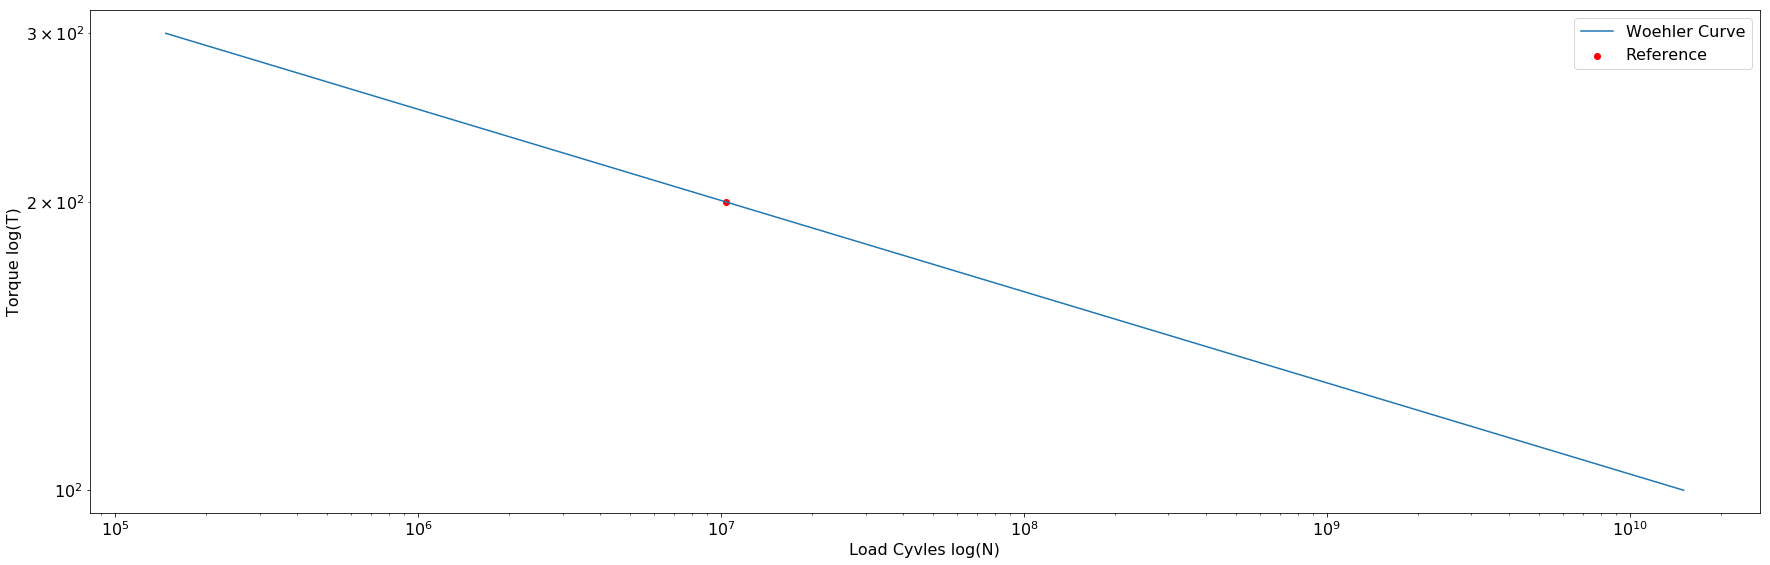

In [115]:
k, n_p, torq_p = 10.5, 10390000., 200.
torq, N = np.linspace(torq_p*0.5, torq_p*1.5, 10), n_p * np.power((torq / torqp), -1*k)

plt.plot(N, torq), plt.scatter(n_p, torq_p, c='r')
plt.xscale('log'), plt.yscale('log'), plt.xlabel('Load Cyvles log(N)'), plt.ylabel('Torque log(T)'), plt.legend(['Woehler Curve', 'Reference'])
plt.show()

<h3>GridSearch</h3>
<br>

<p>Definition of <u>Slices</u> for Exponential Function Parameters &theta;</p>
<li>Function: a = &theta;<sub>1</sub> * exp(&theta;<sub>2</sub> * n) + &theta;<sub>3</sub></li>
<li>Two points Given: (a<sub>0</sub>, n<sub>0</sub>) and (a<sub>eol</sub>, n<sub>eol</sub>)</li>
<li>GridSearch for best fit</li>
<li>Only failing teeth</li>

<p>The definition of the reference points (np, torquep) also determines the probability of failure Px for which the Woehler line applies.</p>



In [ ]:
Deg_Gear['GridSearch'] = {'slice_theta1': (0.0001, 0.0902, 0.01), 'slice_theta2': (0.10/1e6, 1.51/1e6, 0.2/1e6), 'slice_theta3':(-2.0, 0.5, 0.1)}



In [26]:
Deg_Gear['Chances'] = {'neighbouring': 1, 'opposite': 1, 'keeporder': 1}  
deg_model = Gear_Degradation(10, Deg_Gear, 10)
deg_model.get_initial_values()

deg_model.state0

,a0,n0,tooth,neol,aeol
0,0.530981,5.678158e+06,1,1.179216e+07,4.0
1,0.396747,5.737965e+06,10,8.762693e+06,4.0
2,-0.021347,5.858786e+06,7,1.066958e+07,4.0
3,0.483107,7.017299e+06,9,1.020615e+07,4.0
4,0.639507,7.115748e+06,6,1.039452e+07,4.0
5,0.856134,7.330977e+06,4,1.104427e+07,4.0
6,0.230374,7.343730e+06,2,1.050430e+07,4.0
7,0.447443,7.957773e+06,5,1.038117e+07,4.0
8,0.668160,8.141798e+06,8,1.114319e+07,4.0
9,0.451309,8.438217e+06,3,9.631750e+06,4.0


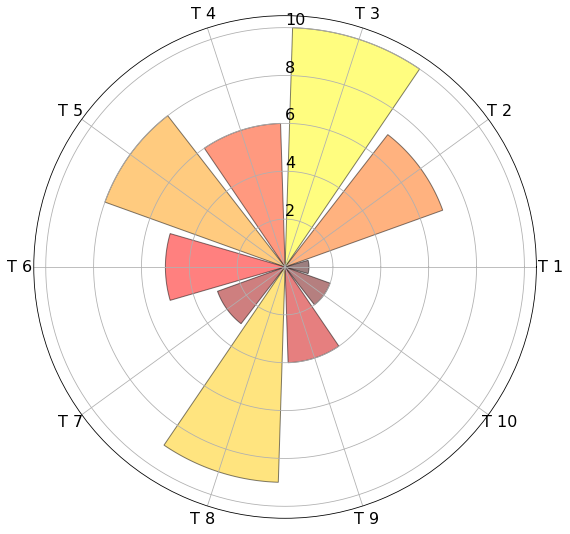

In [27]:
gf.plot_gear_polar(deg_model.state0, kind='order')

In [26]:
Deg_Gear['Chances'] = {'neighbouring': 1, 'opposite': 1, 'keeporder': 1}  
deg_model = Gear_Degradation(10, Deg_Gear, 10)
deg_model.get_initial_values()

deg_model.state0

,a0,n0,tooth,neol,aeol
0,0.530981,5.678158e+06,1,1.179216e+07,4.0
1,0.396747,5.737965e+06,10,8.762693e+06,4.0
2,-0.021347,5.858786e+06,7,1.066958e+07,4.0
3,0.483107,7.017299e+06,9,1.020615e+07,4.0
4,0.639507,7.115748e+06,6,1.039452e+07,4.0
5,0.856134,7.330977e+06,4,1.104427e+07,4.0
6,0.230374,7.343730e+06,2,1.050430e+07,4.0
7,0.447443,7.957773e+06,5,1.038117e+07,4.0
8,0.668160,8.141798e+06,8,1.114319e+07,4.0
9,0.451309,8.438217e+06,3,9.631750e+06,4.0


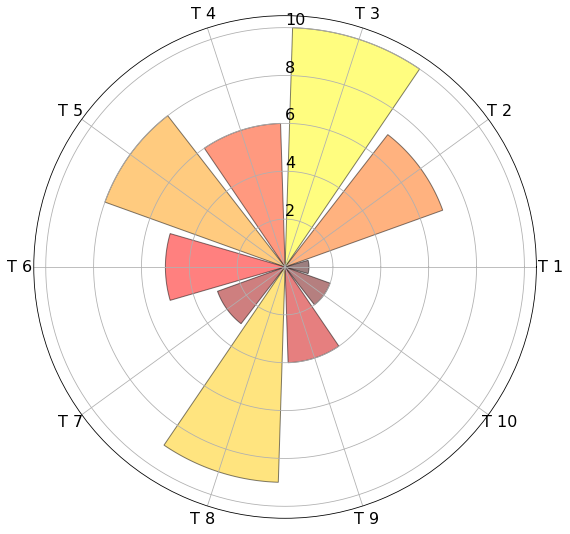

In [27]:
gf.plot_gear_polar(deg_model.state0, kind='order')

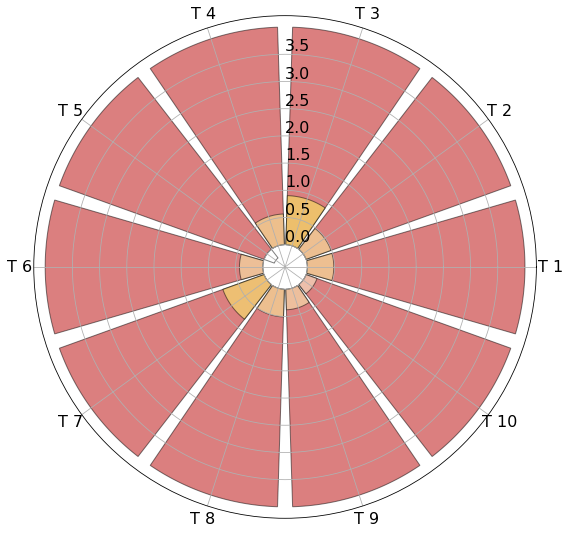

In [21]:
gf.plot_gear_polar(deg_model.state0, kind='pitting_growth', key1='a0', key2='aeol')

<li>opposite:</li>


<a name="ElementMethod"><h3>Element Method</h3></a>

<li>Creating Degradation Behaviour Gear Elements</li>
<li>Based on [Gretzinger2018]</li>
<li>Degradation of Bearing Elements is not implemented yet</li>


<h1> <a name="degradation vibration"></a>Degradation based Vibration</h1>

<p>Module Methods Structure:</p>


<h1> <a name="puttogether"></a>Putting everything together</h1>

<p>Load Gearbox Simulation Toolbox:</p>

In [ ]:
# os.chdir()
os.chdir(hd)
from gearbox import Gearbox
os.chdir(wd)

<p>Define General Input Arguments:</p>

In [ ]:
rotational_frequency_in = 5.2 # U/s | float
number_of_load_cycle = 0 # | Must be float in .3f 
sample_interval = 1 # s | float
sample_rate = 1000 # Hz | float
seed = 5 

<p>Define Vibration Elements:</p>

In [ ]:
GearIn = {'no_teeth': 10,                                         # Number of teeth
          'signal': 'gausspulse',                                 # Signal type for gear
          'ampl_method': 'gaussian_repeat',                       # Amplitude Method for inner gear
          'ampl_attributes': {'mu': 4, 'sigma': 0.5},             # Attributes regarding Amplitude Method for gear signal
          'noise_method': None,                             # Noise Method for inner gear
          'noise_attributes': {'mu': 0, 'sigma': 0.25},           # Attributes regarding Noise Method for gear signal
          'torq_method': None,                                    # Torque Influence Method for inner gear
          'torq_attributes': {'scale_min': 0,                     # Attributes regarding Torque Influence Method for gear signal
                              'scale_max': 0.2,
                               'value_min': 0,
                               'value_max': 50,
                              'norm_divisor': 200,
                              'exponent': 2},           
          }

GearOut = {'no_teeth': 12,                                        # Number of teeth
           'signal': 'gausspulse',                                # Signal type for gear
           'ampl_method': 'gaussian_repeat',                      # Amplitude Method for inner gear
           'ampl_attributes': {'mu': 3, 'sigma': 0.5},            # Attributes regarding Amplitude Method for gear signal
           'noise_method': None,                            # Noise Method for inner gear
           'noise_attributes': {'mu': 0, 'sigma': 0.25},          # Attributes regarding Noise Method for gear signal
           'torq_method': None,                                   # Torque Influence Method for inner gear
           'torq_attributes': {'scale_min': 0,                    # Attributes regarding Torque Influence Method for gear signal
                               'scale_max': 0.2,
                               'value_min': 0,
                               'value_max': 50,
                               'norm_divisor': 1,
                               'exponent': 4},           
          }

In [ ]:
# General Definition of Amplitudes etc. (can be also defined seperatedly for each Bearing)
BearingI =   {# Inner Ring Rollover
             'signal_iring': 'sine',                               # Signal type for inner cage
             'ampl_method_iring': 'const',                         # Amplitude Method for inner cage signal (Repeat methods are not working for bearings)
             'ampl_attributes_iring': {'constant': 2.5},           # Attributes regarding Amplitude Method for inner cage signal
             'noise_method_iring': 'gaussian',                     # Noise Method for inner gear
             'noise_attributes_iring': {'mu': 0, 'sigma': 0.05},   # Attributes regarding Noise Method for gear signal
             'torq_method_iring': None,                         # Torque Influence Method for rolling element
             'torq_attributes_iring': {'scale_min': 0,          # Attributes regarding Torque Influence Method for rolling element signal
                                       'scale_max': 0.1,
                                       'value_min': 0,
                                       'value_max': 50,
                                       'norm_divisor': 1,
                                       'exponent': 4},           

             # Rolling Element:
             'signal_relement': 'sine',                            # Signal type for rolling element
             'ampl_method_relement': 'const',                      # Amplitude Method for rolling element signal (Repeat methods are not working for bearings)
             'ampl_attributes_relement': {'constant': 1.2},        # Attributes regarding Amplitude Method for rolling element signal
             'noise_method_relement': 'gaussian',                  # Noise Method for rolling element
             'noise_attributes_relement': {'mu': 0, 'sigma': 0.05},# Attributes regarding Noise Method for gear signal
             'torq_method_relement': None,                         # Torque Influence Method for rolling element
             'torq_attributes_relement': {'scale_min': 0,          # Attributes regarding Torque Influence Method for rolling element signal
                                          'scale_max': 0.1,
                                          'value_min': 0,
                                          'value_max': 50,
                                          'norm_divisor': 1,
                                          'exponent': 4},
             # Outer Ring Rollover
             'signal_oring': 'sine',                               # Signal type for inner cage
             'ampl_method_oring': 'const',                         # Amplitude Method for inner cage signal (Repeat methods are not working for bearings)
             'ampl_attributes_oring': {'constant': 2.5},           # Attributes regarding Amplitude Method for inner cage signal
             'noise_method_oring': 'gaussian',                     # Noise Method for inner gear
             'noise_attributes_oring': {'mu': 0, 'sigma': 0.05},   # Attributes regarding Noise Method for gear signal
             'torq_method_oring': None,                         # Torque Influence Method for rolling element
             'torq_attributes_oring': {'scale_min': 0,          # Attributes regarding Torque Influence Method for rolling element signal
                                       'scale_max': 0.1,
                                       'value_min': 0,
                                       'value_max': 50,
                                       'norm_divisor': 1,
                                       'exponent': 4},          
            }

Bearing1 = {**{'no_elements': 11}, **BearingI}                     # Number of rolling elements
Bearing2 = {**{'no_elements': 9}, **BearingI}                     # Number of rolling elements
Bearing3 = {**{'no_elements': 13}, **BearingI}                     # Number of rolling elements
Bearing4 = {**{'no_elements': 12}, **BearingI}                     # Number of rolling elements

<p>Define Degradation Elements:</p>

In [ ]:
# Reference Value for PDFs is given for load defined 'Whoeler' 'torqp'

Deg_GearIn = {'Failing_Teeth': 2,                                      # Number of Teeth falling at Gear
              'Chances': {'neighbouring': 1,                           # Chance that multiple falling teeth are neighbouring 
                          'opposite': 1,                               # Chance that multiple falling teeth are opposite to each other 
                          'keeporder': 10},                            # Chance that multiple falling teeth are keeping order from init to eol
              'PDF_Deg_Init': {'n': norm(loc=6.875e6, scale=1.053e6),  # P(n_0)
                               'a': norm(loc=0.450, scale=0.305)},     # P(a_0)
              'PDF_Deg_EOL': {'n': norm(loc=10390000, scale=1.053e6),  # P(n_eol)
                              'a': norm(loc=4.0, scale=0.)},           # P(a_eol)
              'Woehler': {'k': 10.5,                                   # Woehler Exponent 
                          'np': 10390000,                              # Woehler Reference n
                          'torqp': 200},                               # Woehler Reference sigma in Nm
              'GridSearch': {'slice_theta1': (0.0001, 0.0902, 0.01),   # Grid for function a = theta1 * exp(theta2 * n) + theta3 defined in slices
                             'slice_theta2': (0.10/1e6, 1.51/1e6, 0.2/1e6), #tbd change step to 0.02/1e6
                             'slice_theta3':(-2.0, 0.5, 0.1)}
             }
 
Deg_GearOut = {'Failing_Teeth': 3,                                      # Number of Teeth falling at Gear
               'Chances': {'neighbouring': 2,                           # Chance that multiple falling teeth are neighbouring 
                           'opposite': 2,                               # Chance that multiple falling teeth are opposite to each other 
                           'keeporder': 10},                            # Chance that multiple falling teeth are keeping order from init to eol
               'PDF_Deg_Init': {'n': norm(loc=6.875e6, scale=1.053e6),  # P(n_0)
                                'a': norm(loc=0.450, scale=0.305)},     # P(a_0)
               'PDF_Deg_EOL': {'n': norm(loc=10390000, scale=1.053e6),  # P(n_eol)
                               'a': norm(loc=4.0, scale=0.)},           # P(a_eol)
               'Woehler': {'k': 10.5,                                   # Woehler Exponent 
                           'np': 10390000,                              # Woehler Reference n
                           'torqp': 200},                               # Woehler Reference sigma in Nm
               'GridSearch': {'slice_theta1': (0.0001, 0.0902, 0.01),   # Grid for function a = theta1 * exp(theta2 * n) + theta3 defined in slices
                              'slice_theta2': (0.10/1e6, 1.51/1e6, 0.2/1e6), #tbd change step to 0.02/1e6
                              'slice_theta3':(-2.0, 0.5, 0.1)}
              }

In [ ]:
Deg_Bearing1 = 'tbd'
Deg_Bearing2 = 'tbd'
Deg_Bearing3 = 'tbd'
Deg_Bearing4 = 'tbd'

<p>Define Input Torque (Workaround):</p>

In [ ]:
# Object Torque (Workaround)
sample_time = gf.get_sample_time_torque(rotational_frequency_in, sample_rate, GearIn['no_teeth'], GearOut['no_teeth'])
torque_in = np.sin((2 * np.pi * rotational_frequency_in * sample_time)) * 5 + 200 # Nm | array

<h1> <a name="toolboxinit"></a>Instance Initialization</h1>

<p>Initialize a new Instance:</p>



In [ ]:
model = Gearbox(# Vibration Arguments
                rotational_frequency_in,
                sample_interval, sample_rate,
                GearIn, GearOut,
                Bearing1, Bearing2, Bearing3, Bearing4,
                # Degradation Arguments
                Deg_GearIn, Deg_GearOut,
                Deg_Bearing1, Deg_Bearing2, Deg_Bearing3, Deg_Bearing4,
                # Shared Arguments
                seed=seed, 
                fixed_start=True)

<h1> <a name="runvibration"></a>Run Vibration Only</h1>

<p>Initialize Vibration Module: <b>init_vibration(torque)</b></p>
<p>Input Arguments:</p>
<li>Input Torque</li>
<p>Returns:</p>


In [ ]:
model.Vibration.init_vibration(torque_in)

<p>Get Loads from Torque: <b>get_loads(torque)</b></p>
<p>Input Arguments:</p>
<li>Input Torque</li>
<p>Returns:</p>
<li>Loads Dictionary</li>

In [ ]:
loads = model.Vibration.get_loads(torque)
df_loads = pd.DataFrame(loads)
df_loads.index = df_loads.index.astype(dtype='int32')
df_loads = df_loads.sort_index()

In [ ]:
df_loads

<p>Get Vibration Signal: <b>run_vibration(nolc, torque, statei=None, output=True)</b></p>
<p>Input Arguments:</p>
<li>nolc: current number of load cycle</li>
<li>torque: Input Torque</li>
<li>statei: current degradation state</li>
<li>output: if true method returns vibration signal</li>
<p>Returns:</p>
<li>vibration signal</li>

In [ ]:
vibration = model.Vibration.run_vibration(number_of_load_cycle, torque_in, statei=None, output=True)

In [ ]:
plt.plot(np.arange(0, sample_interval, 1/sample_rate), vibration)
plt.xlabel('Time in seconds'), plt.ylabel('Acceleration in g'), plt.legend(['Vibration Signal'])
plt.show()

<p>Summarize Vibration: <b>summary_vibration()</b></p>

In [ ]:
model.Vibration.summary_vibration()

<h1> <a name="rundegradation"></a>Run Degradation Only</h1>

<p>Initialize Degradation Module: <b>init_degradation()</b></p>
<p>Input Arguments:</p>
<p>Returns:</p>
<li>statei: DataFrame containing the degradation states</li>

In [ ]:
statei = model.Degradation.init_degradation()

In [ ]:
pd.DataFrame(statei['GearIn'])

In [ ]:
pd.DataFrame(statei['GearOut'])

<p>Summarize Vibration: <b>summary_vibration()</b></p>

In [ ]:
model.Degradation.summary_degradation()

<p>Get Degradation Growth: <b>run_degradation(nolc, loads)</b></p>
<p>Input Arguments:</p>
<li>nolc: current number of load cycle (must be greater than the previous given nolc)</li>
<li>loads: Dictionary regarding get_loads(torque) return</li>
<p>Returns:</p>
<li>statei </li>

In [ ]:
loads = {'GearIn': {'3': [200], '10': [200]},
         'GearOut': {'2': [200], '11': [200], '12': [200]}}

for nolc in np.linspace(1e6, 6e6, 50):
    statei = model.Degradation.run_degradation(nolc, loads)

In [ ]:
pd.DataFrame(statei['GearIn'])

In [ ]:
pd.DataFrame(statei['GearOut'])

In [ ]:
model.Degradation.summary_degradation()

In [ ]:

loads = {'GearIn': {'3': [188], '10': [212]},
         'GearOut': {'2': [205], '11': [195], '12': [200]}}

for nolc in np.linspace(6e6, 10e6, 40):
    statei = model.Degradation.run_degradation(nolc, loads)

In [ ]:
pd.DataFrame(statei['GearIn'])

In [ ]:
pd.DataFrame(statei['GearOut'])

In [ ]:
model.Degradation.summary_degradation()

<h1> <a name="rundegradation"></a>Run Gearbox Simulation (Degradation & Vibration)</h1>

<p>Initialize Degradation Module: <b>initialize(torque)</b></p>
<p>Input Arguments:</p>
<li>torque: input torque</li>
<p>Returns:</p>

In [ ]:
model.initialize(torque_in)

<p>Run Vibration and Degradation: <b>run(nolc, output=True)</b></p>
<p>Input Arguments:</p>
<li>nolc: current number of load cycle (must be greater than the previous given nolc)</li>
<li>output: if true returns vibration signal</li>
<p>Returns:</p>
<li>vibration (if output is True)</li>

<p>Set Torque for upcoming cycles: <b>set(nolc, torque)</b></p>
<p>Input Arguments:</p>
<li>nolc: current number of load cycle (must be <b>equal</b> to the previous nolc in run())</li>
<li>torque: input torque</li>
<p>Returns:</p>


In [ ]:
for nolc in np.linspace(1e6, 6e6, 10):
    vibration = model.run(nolc, output=True)
    model.set(nolc, torque_in)

<p>Summarize Vibration and Degradation: <b>summary()</b></p>

In [ ]:
model.summary()

<h1>Thank you for your attention</h1>
<br>
<p>Mark Henss</p>
<p>Institute of Machine Components</p>
<p>University of Stuttgart</p>

In [ ]:
questions = input("Questions?")

In [ ]:
#%% Parameter Pipeline
alpha = 0.01 #tukey window parameter
pp = 40 #pooling_parameter - window size
yf, xf = gf.rfft_y(vibration, alpha, sample_rate, pp, scale=False)

In [ ]:
plt.figure(figsize=[15,10])
plt.plot(xf, yf)